
## `Лабораторная работа №2 "Сегментация изображений"`



#### Фамилия, имя: Игнаткин Максим

Дата выдачи: <span style="color:red">__11 декабря__</span>.

Срок сдачи: <span style="color:red">__25 декабря__</span>.

Максимальная оценка: __10 баллов__




## `Задание 1. Загрузка данных (1 балла)`

PyTorch использует абстрактный класс **`Dataset`** для работы с данными. Этот класс определен в модуле `torch.utils.data.dataset`


```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Например, в PyTorch уже есть готовый класс `torchvision.datasets.ImageFolder`.

Он создаёт датасет из папок, где каждая подпапка соответствует отдельному классу изображений (как в структуре ImageNet: `./train/класс/` и `./val/класс/`).

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для [данных](https://drive.google.com/file/d/1DvbvhSI4LBUgqR1vcEYaIjuOhoenV1-2/view?usp=sharing) - фотографии людей.


In [1]:
import os
import random

import numpy as np
import numpy.testing as npt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg13, VGG13_Weights
from PIL import Image, ImageEnhance
from tqdm import trange
from tqdm import tqdm

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks.
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms

        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(target_dir))

        self.mask_map = {
            os.path.splitext(f)[0]: f for f in self.mask_files
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)

        stem = os.path.splitext(image_name)[0]

        if stem not in self.mask_map:
            raise FileNotFoundError(f"Маска для изображения не найдена {image_name}")

        mask_name = self.mask_map[stem]
        mask_path = os.path.join(self.target_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms is not None:
            image, mask = self.transforms(image, mask)

        return image, mask

## `Задание 2. Преобразование и аугментация (1 балла)`

При создании датасета с `ImageFolder` вы можете указать функции преобразования через параметры `transform` (для изображений) и `target_transform` (для меток).

Это позволяет автоматически конвертировать `PIL.Image` в тензоры и применять аугментацию.

**Аугментация** — случайные трансформации для повышения разнообразия обучающей выборки.

В PyTorch уже есть набор готовых преобразований в `torchvision.transforms`, но вы легко можете создать свои, определив класс с методами `__init__` и `__call__`.

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).


**1)** Реализуйте преобразования для аугментации данных, каждое из которых выполняется с вероятностью p:

- зеркальное отображение по горизонтальной оси,

- изменение яркости с заданной степенью изменения,

- замена фона на случайную текстуру из указанного набора.



In [3]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        return image, mask

In [4]:
class RandomBrightness:
    def __init__(self, p=0.5, brightness=0.3):
        self.p = p
        self.brightness = brightness

    def __call__(self, image, mask):
        if random.random() < self.p:
            enhancer = ImageEnhance.Brightness(image)
            factor = 1 + random.uniform(-self.brightness, self.brightness)
            image = enhancer.enhance(factor)
        return image, mask

In [5]:
class RandomBackground:
    def __init__(self, textures_dir, p=0.5):
        self.p = p
        self.textures = [
            os.path.join(textures_dir, f)
            for f in os.listdir(textures_dir)
        ]

    def __call__(self, image, mask):
        if random.random() >= self.p:
            return image, mask

        texture_path = random.choice(self.textures)
        texture = Image.open(texture_path).convert("RGB")
        texture = texture.resize(image.size)

        image_np = np.array(image)
        texture_np = np.array(texture)
        mask_np = np.array(mask)

        image_np[mask_np == 0] = texture_np[mask_np == 0]

        image = Image.fromarray(image_np)
        return image, mask

**2)** Добавьте случайные преобразования в датасеты.

Сделайте конвертацию в тензоры PyTorch и нормализацию:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [6]:
class ToTensorJoint:
    def __init__(self):
        self.img_tf = transforms.ToTensor()
        self.mask_tf = transforms.ToTensor()

    def __call__(self, image, mask):
        image = self.img_tf(image)
        mask = self.mask_tf(mask)
        return image, mask

In [7]:
class NormalizeJoint:
    def __init__(self, mean, std):
        self.norm = transforms.Normalize(mean, std)

    def __call__(self, image, mask):
        image = self.norm(image)
        return image, mask

In [8]:
class JointCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

In [9]:
train_transforms = JointCompose([
    RandomHorizontalFlip(p=0.5),
    RandomBrightness(p=0.5, brightness=0.3),
    ToTensorJoint(),
    NormalizeJoint(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = JointCompose([
    ToTensorJoint(),
    NormalizeJoint(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
import os
DATA_PATH = "people_data"

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "train"),
    target_dir=os.path.join(DATA_PATH, "train_mask"),
    transforms=train_transforms
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "test"),
    target_dir=os.path.join(DATA_PATH, "test_mask"),
    transforms=test_transforms
)

In [11]:
print("Размер тестовой выборки:", len(test_dataset))
print("Размер обучающей выборки:", len(train_dataset))

img, mask = test_dataset[0]
print("Размерность изображения:", img.shape)
print("Размерность маски:", mask.shape)
print("Уникальные значения маски (классы):", torch.unique(mask))

Размер тестовой выборки: 141
Размер обучающей выборки: 1350
Размерность изображения: torch.Size([3, 320, 240])
Размерность маски: torch.Size([1, 320, 240])
Уникальные значения маски (классы): tensor([0., 1.])


Функция для отображения изображения:

In [12]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

**3)** Визуализируйте результаты аугментации данных.

Для каждого преобразования предоставьте изображения с соответствующими масками, демонстрирующие корректность обработки.

Отдельно проверьте каждую аугментацию — объединение нескольких преобразований в одном примере недопустимо.

In [13]:
original_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "train"),
    target_dir=os.path.join(DATA_PATH, "train_mask"),
    transforms=JointCompose([
        ToTensorJoint(),
        NormalizeJoint(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
)

In [14]:
def show_original_and_augmented(original_dataset, augmented_dataset, idx):
    print("Оригинал")
    show_idx_image(original_dataset, idx)

    print("Аугментированное изображение")
    show_idx_image(augmented_dataset, idx)

Оригинал


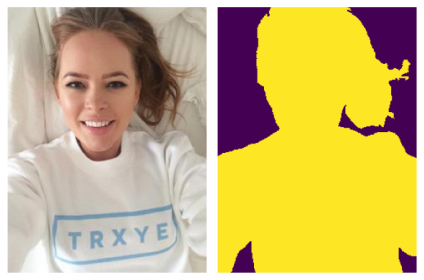

Аугментированное изображение


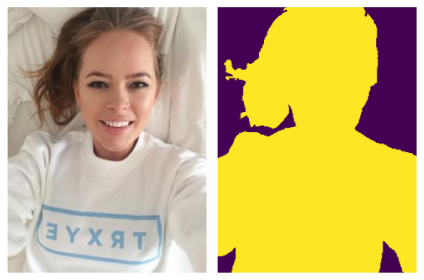

In [15]:
flip_only_transforms = JointCompose([
    RandomHorizontalFlip(p=1.0),
    ToTensorJoint(),
    NormalizeJoint(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

flip_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "train"),
    target_dir=os.path.join(DATA_PATH, "train_mask"),
    transforms=flip_only_transforms
)

show_original_and_augmented(original_dataset, flip_dataset, idx=0)

Оригинал


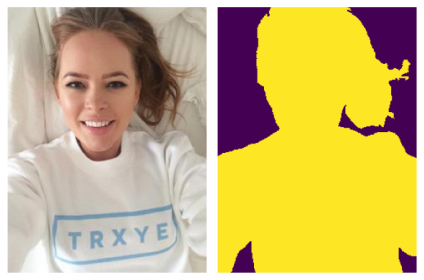

Аугментированное изображение


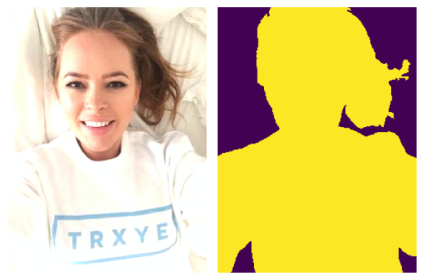

In [16]:
brightness_only_transforms = JointCompose([
    RandomBrightness(p=1.0, brightness=0.5),
    ToTensorJoint(),
    NormalizeJoint(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

brightness_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "train"),
    target_dir=os.path.join(DATA_PATH, "train_mask"),
    transforms=brightness_only_transforms
)

show_original_and_augmented(original_dataset, brightness_dataset, idx=0)

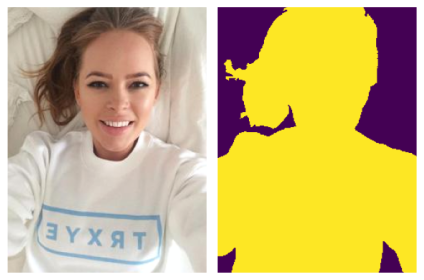

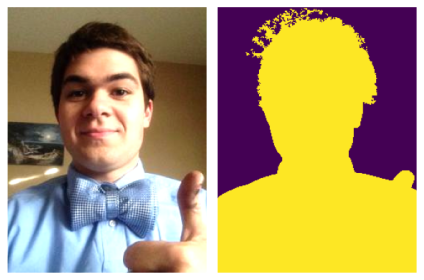

In [17]:
show_idx_image(train_dataset, 0)
show_idx_image(train_dataset, 1)

**4)** Оптимизация загрузки данных с помощью `DataLoader`

Для эффективного обучения нейронных сетей в PyTorch рекомендуется использовать не просто датасеты, а специальные загрузчики данных `DataLoader` - удобный интерфейс для итерации по данным батчами.

Ключевые параметры `DataLoader`:

-`batch_size` — размер мини-батча
Определяет количество образцов, обрабатываемых за одну итерацию. Оптимальное значение зависит от доступной видеопамяти GPU и размера модели.

- `shuffle` — перемешивание данных
*True* (для тренировочных данных) — обеспечивает случайный порядок подачи примеров, что улучшает сходимость модели. *False* (для валидационных и тестовых данных).

- `num_workers` — количество процессов загрузки
Значение > 0 — включает параллельную загрузку данных в фоновых процессах.

- `pin_memory` — фиксация памяти
True — ускоряет передачу данных на GPU.

- `persistent_workers` — сохранение рабочих процессов
True — предотвращает пересоздание процессов при каждом эпохе. Эффективно при num_workers > 0

In [18]:
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

## `Задание 3. На основе U-Net разработайте архитектуру для решения задачи сегментации (5 баллов)`


Оргинальная архитектура [U-Net](https://arxiv.org/pdf/1505.04597.pdf):


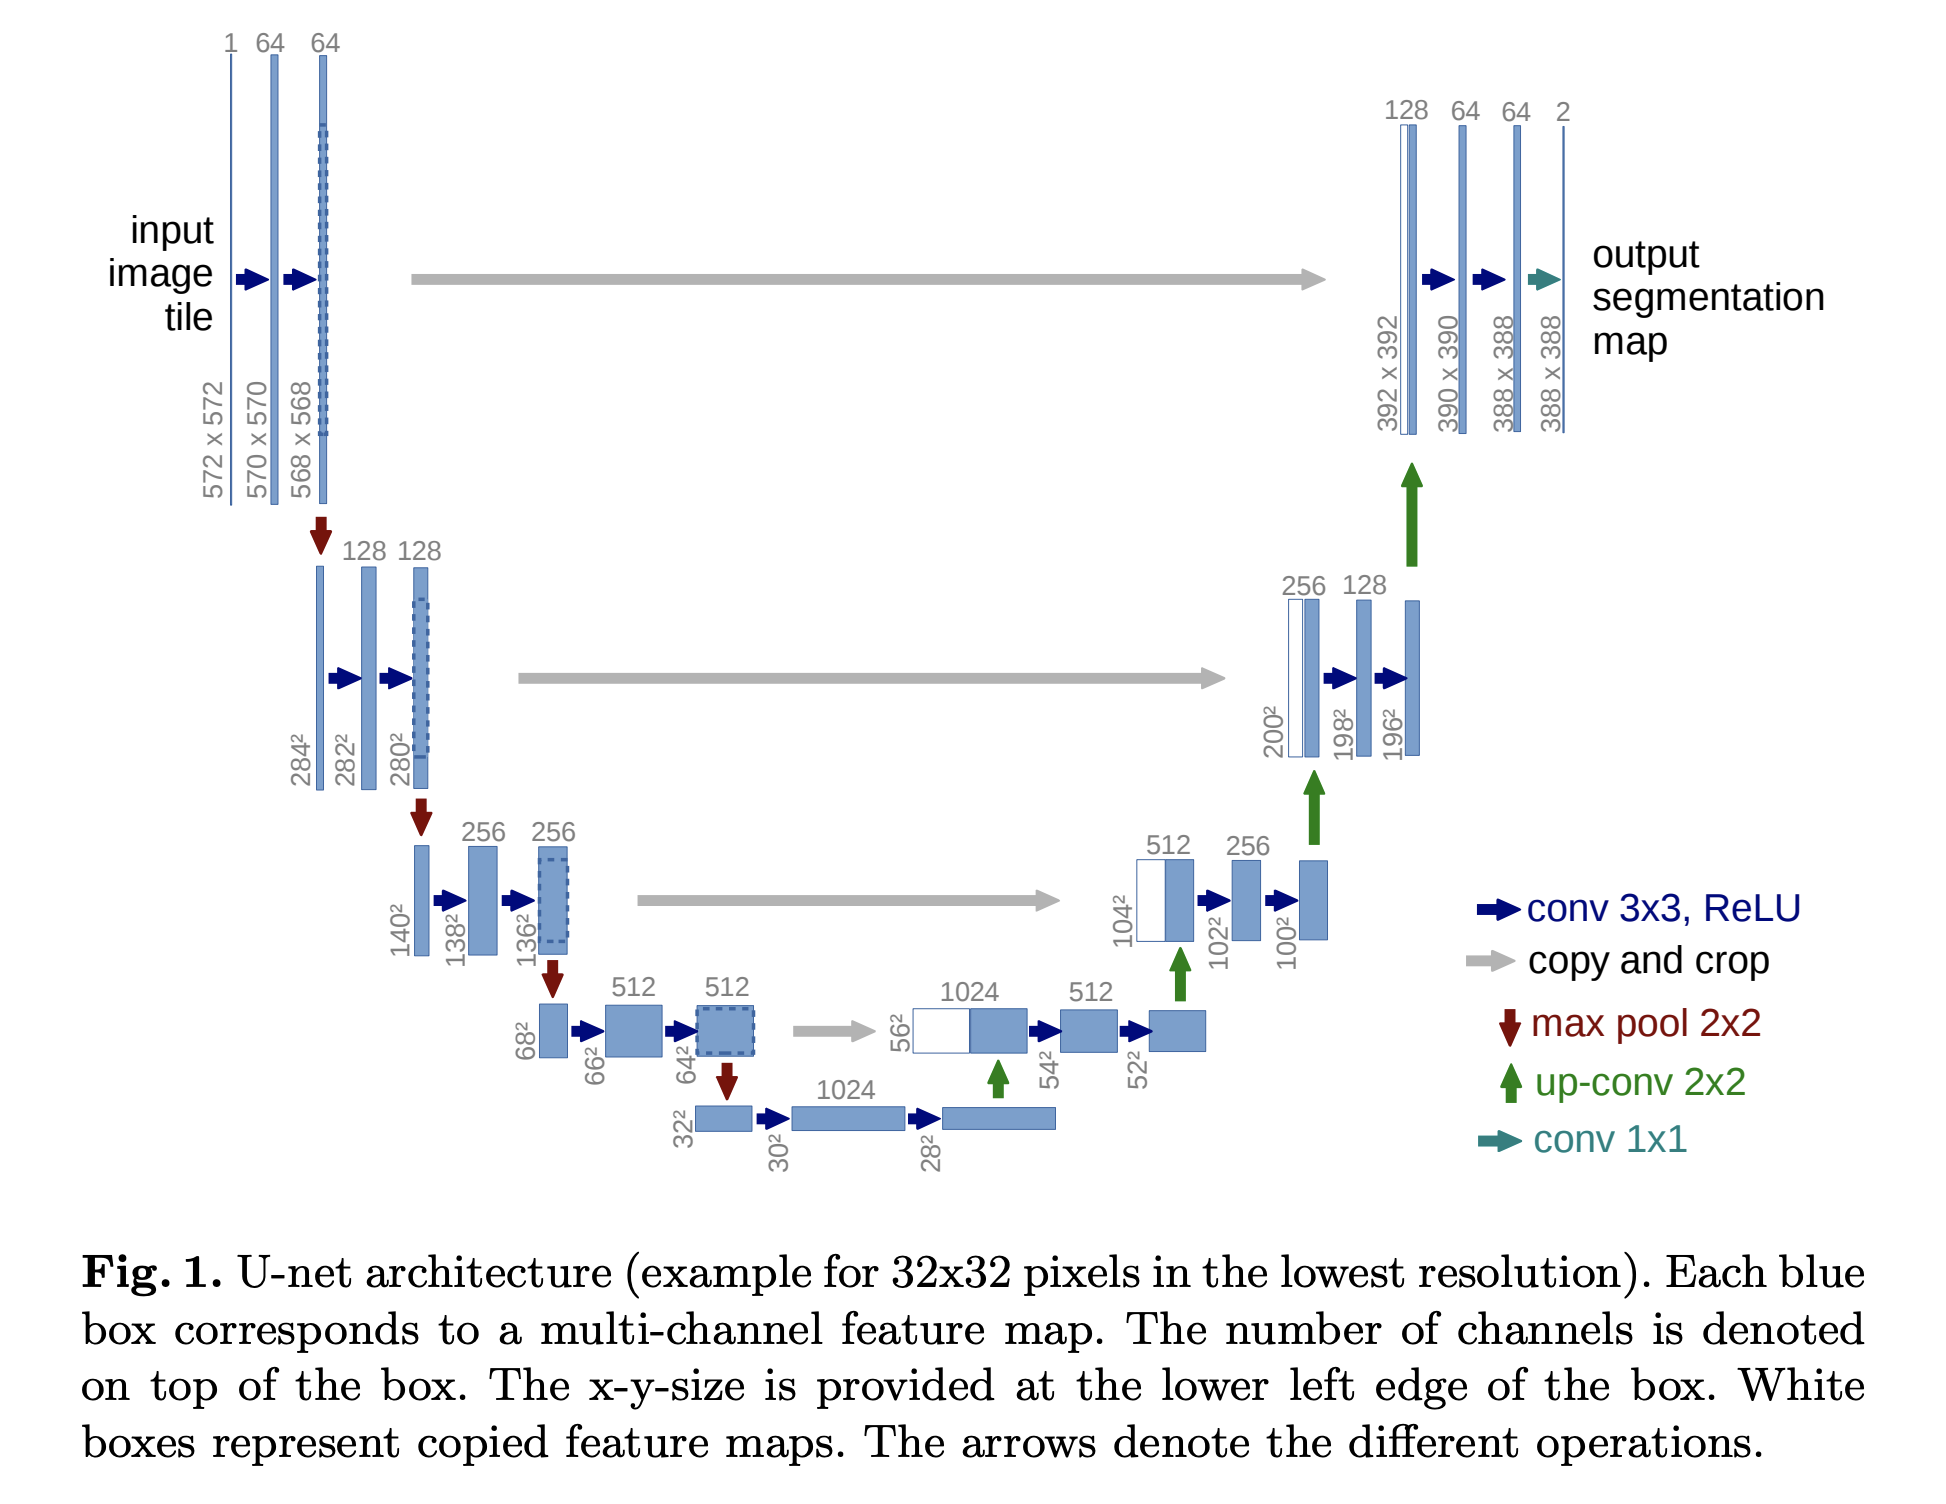

Для решения задачи сегментации изображений можно использовать U-Net с энкодером из первых блоков предобученного `VGG13`.

Исходные блоки `VGG13` организованы как последовательность:

- два свёрточных слоя с активацией `ReLU`,

- слой максимального пулинга `MaxPool2d`.

Для построения энкодера-декодера целесообразно отделить операцию пулинга (downsampling) от свёрточных блоков, то есть:

- убрать MaxPool2d из блоков,

- применить пулинг отдельно.



#### `Encoder`

In [19]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # для извлечения признаков из данных используем предобученную VGG13
        feature_extractor = vgg13(weights=weights).features

        block_indices = [
            (0, 4),
            (5, 9),
            (10, 14),
            (15, 19),
            (20, 24),
        ]

        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            start, end = block_indices[idx]
            self.blocks.append(
                torch.nn.Sequential(*feature_extractor[start:end])
            )

        self.pool = torch.nn.MaxPool2d(2, 2)

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max pool
            if idx != len(self.blocks) - 1:
                x = self.pool(x)

        return activations

In [20]:
# проверьте архитектуру Вашего энкодера
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)
assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`


При реализации `Decoder` пригодится интерполяция для  увеличения размера feature maps перед конкатенацией  (можно использовать `torch.nn.functional.interpolate` с `mode=nearest`-сохранение резкости границ).

Например:

```
# После пулинга в энкодере размерность уменьшается в 2 раза
# В декодере нужно вернуться к исходному размеру
x = F.interpolate(x, scale_factor=2, mode='nearest')
```



In [21]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = F.interpolate(down, scale_factor=2, mode='nearest')
        x = self.relu(self.upconv(x))

        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = torch.cat([left, x], dim=1)

        # Две свёртки с ReLu
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [22]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [23]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()

        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        base_channels = 64

        self.decoder = Decoder(num_filters=base_channels, num_blocks=num_blocks - 1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        self.final = torch.nn.Conv2d(in_channels=base_channels, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)

        return x

In [24]:
# проверьте Вашу U-Net
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
      

### `Оценка качества`

В качестве оценки эффективности модели на целевой задаче отслеживают независимые метрики качества.

Для семантической сегментации стандартной метрикой является **IoU (Intersection over Union, пересечение по объединению)**. Эта метрика измеряет совпадение между предсказанной и истинной масками:

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Знаменатель формулы может обращаться в ноль, например, когда обе маски полностью состоят из нулей (отсутствие объекта). В таких случаях IoU становится неопределённым. При усреднении метрики по батчу или датасету эти случаи следует исключать из расчёта, чтобы избежать появления NaN-значений. В PyTorch для этого предусмотрены функции с префиксом `nan` (например, `torch.nanmean`), которые автоматически игнорируют NaN при агрегации.


In [25]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        preds = (logits > self.threshold).float()

        preds = preds.squeeze(1)
        true_labels = true_labels.squeeze(1)

        intersection = (preds * true_labels).sum(dim=(1, 2))
        union = preds.sum(dim=(1, 2)) + true_labels.sum(dim=(1, 2)) - intersection

        score = intersection / union

        if self.reduction == 'sum':
            score = torch.nansum(score)
        elif self.reduction == 'mean':
            score = torch.nanmean(score)

        return score

In [26]:
# Проверьте Вашу метрику IoU
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

## `Задание 4. Обучение U-Net (3 балла)`

Решается задача семантической сегметанции людей на фото.

Обучите сеть на обучающей выборке (из задания №1,2") и протестируйте качество на тестовой выборке.

В качестве лосс функции можно использовать кросс-энтропию (`torch.nn.BCEWithLogitsLoss`).

**Отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

### Preparation

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(num_classes=1, num_blocks=3).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

iou_metric = IoUScore(threshold=0.0, reduction='mean')

Device: cuda


### Training and validation functions

In [28]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()

    total_loss = 0.0
    total_iou = 0.0
    n_batches = 0

    for images, masks in tqdm(dataloader, desc="Train", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += iou_metric(logits, masks).item()
        n_batches += 1

    return total_loss / n_batches, total_iou / n_batches

@torch.no_grad()
def evaluate(model, dataloader, criterion):
    model.eval()

    total_loss = 0.0
    total_iou = 0.0
    n_batches = 0

    for images, masks in tqdm(dataloader, desc="Val", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        loss = criterion(logits, masks)

        total_loss += loss.item()
        total_iou += iou_metric(logits, masks).item()
        n_batches += 1

    return total_loss / n_batches, total_iou / n_batches

### Training

In [29]:
num_epochs = 10

train_losses, test_losses = [], []
train_ious, test_ious = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_iou = train_one_epoch(
        model, train_data_loader, optimizer, criterion
    )
    test_loss, test_iou = evaluate(
        model, test_data_loader, criterion
    )

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_ious.append(train_iou)
    test_ious.append(test_iou)

    print(
        f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} | "
        f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}"
    )


Epoch 1/10


Train Loss: 0.4310, Train IoU: 0.7260 | Test Loss: 0.3474, Test IoU: 0.7736

Epoch 2/10


Train Loss: 0.3347, Train IoU: 0.7813 | Test Loss: 0.3469, Test IoU: 0.7586

Epoch 3/10


Train Loss: 0.3091, Train IoU: 0.7959 | Test Loss: 0.2957, Test IoU: 0.8054

Epoch 4/10


Train Loss: 0.2847, Train IoU: 0.8114 | Test Loss: 0.2813, Test IoU: 0.8183

Epoch 5/10


Train Loss: 0.2720, Train IoU: 0.8201 | Test Loss: 0.2726, Test IoU: 0.8222

Epoch 6/10


Train Loss: 0.2686, Train IoU: 0.8235 | Test Loss: 0.2503, Test IoU: 0.8367

Epoch 7/10


Train Loss: 0.2476, Train IoU: 0.8350 | Test Loss: 0.2416, Test IoU: 0.8434

Epoch 8/10


Train Loss: 0.2403, Train IoU: 0.8388 | Test Loss: 0.2481, Test IoU: 0.8407

Epoch 9/10


Train Loss: 0.2379, Train IoU: 0.8425 | Test Loss: 0.2489, Test IoU: 0.8311

Epoch 10/10


Train Loss: 0.2319, Train IoU: 0.8442 | Test Loss: 0.2410, Test IoU: 0.8423


### Loss and IoU

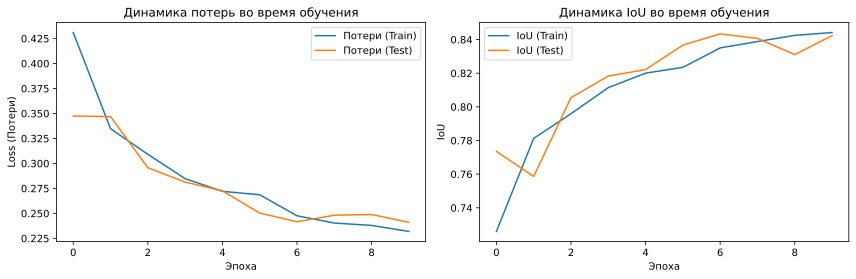

In [33]:
plt.figure(figsize=(12, 4))

# График потерь (Loss)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Потери (Train)")
plt.plot(test_losses, label="Потери (Test)")
plt.xlabel("Эпоха")
plt.ylabel("Loss (Потери)")
plt.title("Динамика потерь во время обучения")
plt.legend()

# График IoU
plt.subplot(1, 2, 2)
plt.plot(train_ious, label="IoU (Train)")
plt.plot(test_ious, label="IoU (Test)")
plt.xlabel("Эпоха")
plt.ylabel("IoU")
plt.title("Динамика IoU во время обучения")
plt.legend()

plt.tight_layout()
plt.show()

### Predictions

In [31]:
def show_predictions(model, dataset, idx):
    model.eval()

    image, mask = dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        pred = (logits > 0).float()

    image = image.squeeze(0).cpu()
    mask = mask.squeeze(0).cpu()
    pred = pred.squeeze(0).squeeze(0).cpu()

    img = image.permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].imshow(img)
    axes[0].set_title("Image")

    axes[1].imshow(mask.numpy(), cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("True mask")

    axes[2].imshow(pred.numpy(), cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Predicted mask")

    for ax in axes:
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

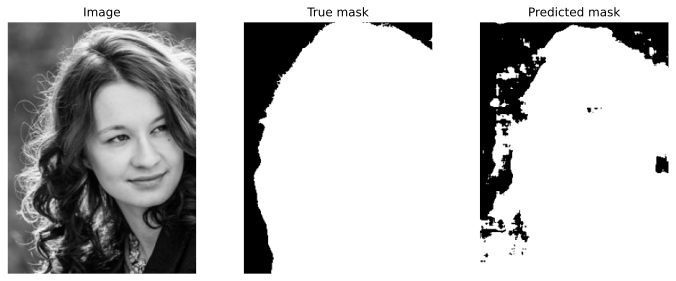

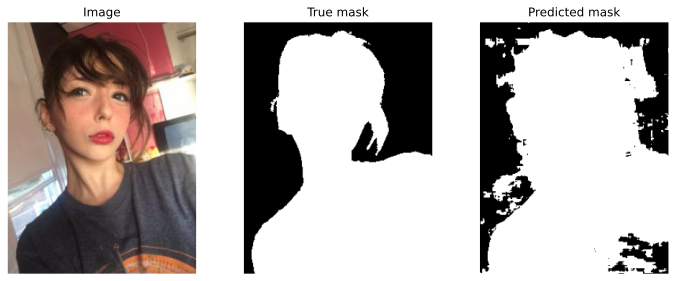

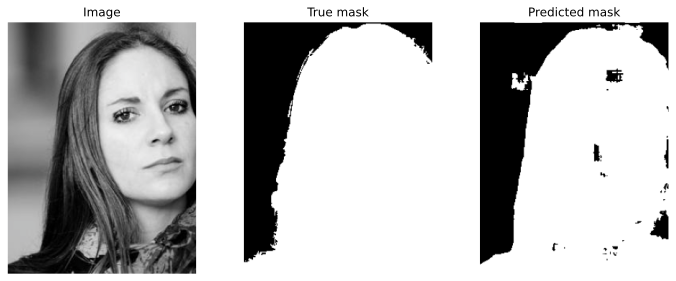

In [32]:
show_predictions(model, test_dataset, 6)
show_predictions(model, test_dataset, 7)
show_predictions(model, test_dataset, 8)

В ходе работы была применена архитектура U-Net для решения задачи сегментации людей. Обучение проводилось с использованием оптимизатора Adam и функции потерь BCEWithLogitsLoss. Анализ графиков обучения демонстрирует стабильное снижение ошибки и рост метрики IoU на обеих выборках, что говорит об отсутствии явного переобучения. Итоговый показатель IoU составил 0.842, что свидетельствует о достойном качестве модели. Визуальная оценка масок подтверждает способность сети выделять силуэты, однако наблюдаются небольшие погрешности в прорисовке границ объектов.

## **Сдача работы**

Результатом выполнения лабораторной работы является
ссылка на Google Collab (не забудьте открыть доступ), либо файл .ipynb.

